## Crack Detection

For the purpose of crack detection, my approach is to extract visual features from image to identify cracks and the location

In [1]:
import os, cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def hsv_mask(img_dir, v_const = 10):
    '''
    Create a mask based on image's HSV v-value. Get the darker regions in the image (cracks are darker)
    Input:
    img_dir: image directory
    v_const: select pixels with v value lower than the average_v - v_const
    Output:
    mask: mask image (255 for positive pixels, else 0)
    '''
    # load image
    img = cv2.imread(img_dir)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV color space 
    
    # create mask based on HSV v-value
    v_avg = np.average(img_hsv[:,:,2]) # value average
    lb = (0,0,0) # lower bound
    ub = (179,255,v_avg - v_const) # upper bound
    mask = cv2.inRange(img_hsv, lb, ub) # remove pixels too bright (e.g. white line)
    
    return mask
     

In [3]:
def thresh_mask(img_dir, AT_block = 55, AT_C = 10):
    '''
    Create a mask using adaptive gaussian thresholding
    Input:
    img_dir: image directory
    AT_block: neighborhood area
    AT_C: constant to be subtracted from mean
    Output:
    mask: mask image (255 for positive pixels, else 0)
    '''
    # load grayscale img
    img_gray = cv2.imread(img_dir,0)
    
    # adaptive gaussian thresholding
    th3 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,AT_block,AT_C)
    th = np.ones(img_gray.shape)*255
    mask = th - th3
    
    return mask

In [4]:
def erode_dilate(mask,e_kernel = 2,d_kernel = 2,e_iter = 1 ,d_iter = 1):
    ''' Erode and dilate the mask image to reduce noise and combine segmented regions'''
    kernel_e = np.ones((e_kernel,e_kernel), np.uint8)
    kernel_d = np.ones((d_kernel,d_kernel), np.uint8)
    img_erosion = cv2.erode(mask, kernel_e, iterations = e_iter) 
    img_dilation = cv2.dilate(img_erosion, kernel_d, iterations = d_iter)
    return img_dilation

In [5]:
def remove_blob_size(res, min_size = 30, con = 8):
    '''
    Connect components in image and remove smaller noise spots based on size
    Input:
    res: mask image
    min_size : minimum size of particles we want to keep
    connectivity: 4 or 8 (connectivity of components)
    Output:
    img_out: output image 
    '''
    #find all connected components and stats 
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(res.astype(np.uint8), connectivity=con)
    
    #remove background component and get size data
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    
    # init output image
    img_out = np.zeros((output.shape))
    # only keep component satisfy size requirement
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img_out[output == i + 1] = 255
    return img_out

In [6]:
def remove_blob_len(res, min_l = 50, con = 8):
    '''
    Connect components in image and remove smaller noise spots based on width and height
    Input:
    res: mask image
    min_l : minimum length of particles we want to keep
    connectivity: 4 or 8 (connectivity of components)
    Output:
    img_out: output image 
    '''
    #find all connected components and stats 
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(res.astype(np.uint8), connectivity=con)
    
    #remove background component and get width, height data
    nb_components = nb_components - 1
    widths = stats[1:, -3]
    heights = stats[1:, -2]
    
    # calculate average of the largest 10 width, height 
    r = min(nb_components, 10)
    avg_w = np.average(np.sort(widths)[-r:])
    avg_h = np.average(np.sort(heights)[-r:])
    # average length used for filtering
    avg_l = min(min_l, (avg_w + avg_h) / 2 )
    
    # init output image
    img_out = np.zeros((output.shape))
    #for every component in the image, you keep it only if it' satifies requirement
    for i in range(0, nb_components):
        if widths[i] >= avg_l or heights[i] >= avg_l:
            img_out[output == i + 1] = 255
    return img_out

In [7]:
def detect_crack(i):
    '''
    Detect crack for given index in file name
    '''
    
    # get file name 
    img_name = '0'*(3-len(str(i))) + str(i) +'.jpg'
    file_dir = './samples/' + img_name
    
    # check if file exist
    if os.path.isfile(file_dir):
        # load image 
        img = cv2.imread(file_dir)
        
        # get threshold mask to approximate image contrast
        mask_thresh = thresh_mask(file_dir,25,15)
        
        # high contrast (cracks is distinct from surrounding)
        if np.average(mask_thresh) > 15:
            print('high contrast')
            # create mask based on HSV v-value
            mask_hsv = hsv_mask(file_dir,10)
            # adaptive gaussian thresholding
            mask_thresh = thresh_mask(file_dir,25,10)
            # combine two masks
            res = mask_hsv * mask_thresh / 255.0
            # connect components and remove blobs 
            img2 = remove_blob_size(res,20,8)
            # erode and dilate to remove noise and connect regions
            res2 = erode_dilate(img2,1,2,1,1)
            # select top areas with high width or height values
            res3 = remove_blob_len(res2,50)
            
        # low contrast (crack is similar to surrounding)
        else:
            print('low contrast')
            # create mask based on HSV v-value
            mask_hsv = hsv_mask(file_dir,0)
            # adaptive gaussian thresholding
            mask_thresh = thresh_mask(file_dir,105,10)
            # combine two masks
            res = mask_hsv * mask_thresh / 255.0
            # connect components and remove blobs 
            img2 = remove_blob_size(res,20,8)
            # erode and dilate to remove noise and connect regions
            res2 = erode_dilate(img2,1,2,1,2)
            # select top areas with high width or height values
            res3 = remove_blob_len(res2,40)
        

        # plot results
        plt.figure(figsize=(10,15))
        plt.subplot(2, 1, 1)
        img[:,:,2][res3 > 0] = 255
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.subplot(2, 1, 2)
        plt.imshow(res3,'gray')
        plt.show()

In [7]:
def detect_crack(i):
    '''
    Detect crack for given index in file name
    '''
    # load image 
    img = cv2.imread(file_dir)

    # get threshold mask to approximate image contrast
    mask_thresh = thresh_mask(file_dir,25,15)

    # high contrast (cracks is distinct from surrounding)
    if np.average(mask_thresh) > 15:
        print('high contrast')
        # create mask based on HSV v-value
        mask_hsv = hsv_mask(file_dir,10)
        # adaptive gaussian thresholding
        mask_thresh = thresh_mask(file_dir,25,10)
        # combine two masks
        res = mask_hsv * mask_thresh / 255.0
        # connect components and remove blobs 
        img2 = remove_blob_size(res,20,8)
        # erode and dilate to remove noise and connect regions
        res2 = erode_dilate(img2,1,2,1,1)
        # select top areas with high width or height values
        res3 = remove_blob_len(res2,50)

    # low contrast (crack is similar to surrounding)
    else:
        print('low contrast')
        # create mask based on HSV v-value
        mask_hsv = hsv_mask(file_dir,0)
        # adaptive gaussian thresholding
        mask_thresh = thresh_mask(file_dir,105,10)
        # combine two masks
        res = mask_hsv * mask_thresh / 255.0
        # connect components and remove blobs 
        img2 = remove_blob_size(res,20,8)
        # erode and dilate to remove noise and connect regions
        res2 = erode_dilate(img2,1,2,1,2)
        # select top areas with high width or height values
        res3 = remove_blob_len(res2,40)


    # plot results
    plt.figure(figsize=(10,15))
    plt.subplot(2, 1, 1)
    img[:,:,2][res3 > 0] = 255
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(2, 1, 2)
    plt.imshow(res3,'gray')
    plt.show()

List of index in samples: [2, 3, 8, 13, 16, 21, 22, 24, 25, 26, 46, 52, 54, 58, 65, 66, 70, 71, 84, 106]

## Examples:

high contrast


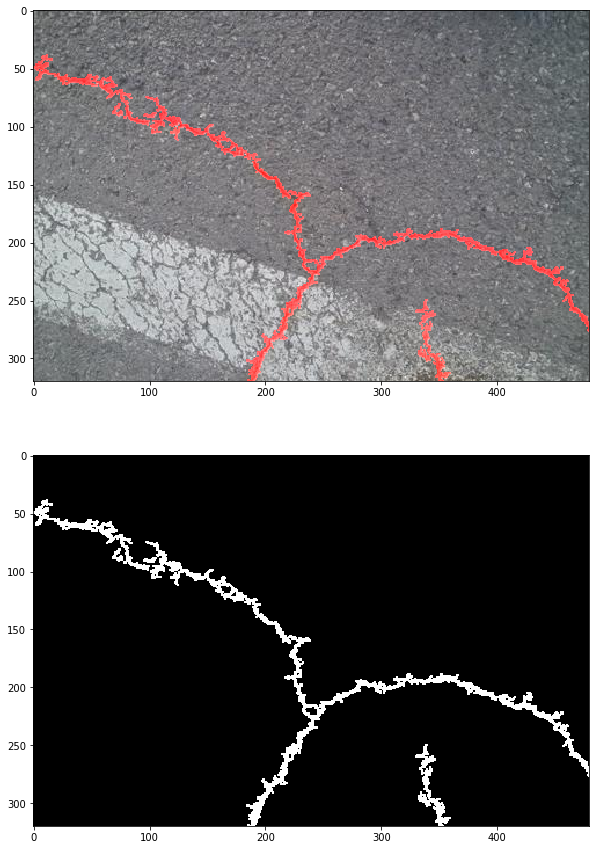

In [8]:
detect_crack(21)

low contrast


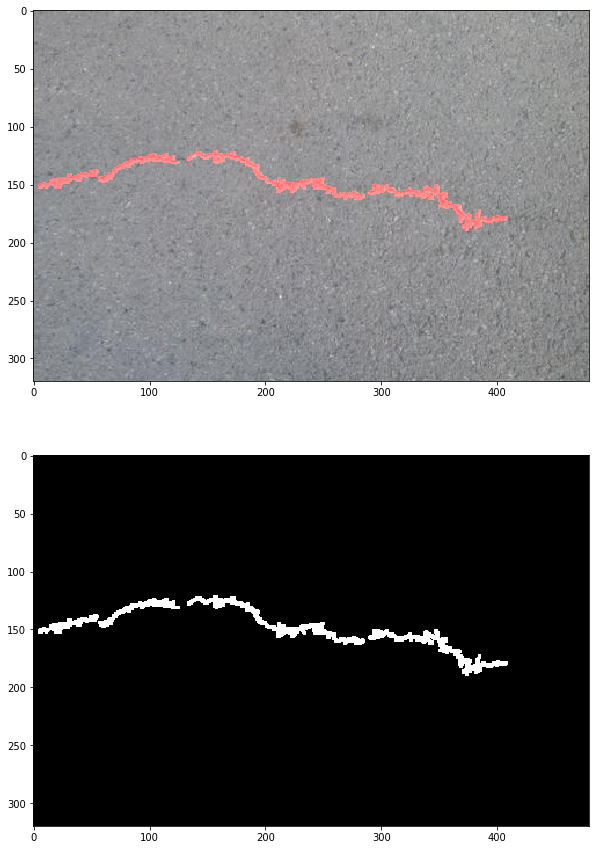

In [9]:
detect_crack(25)

In [10]:
# Generator to iterate through all samples

In [11]:
img_gen = (i for i in range(107) if os.path.isfile('./samples/' +'0'*(3-len(str(i))) + str(i) +'.jpg'))

3
low contrast


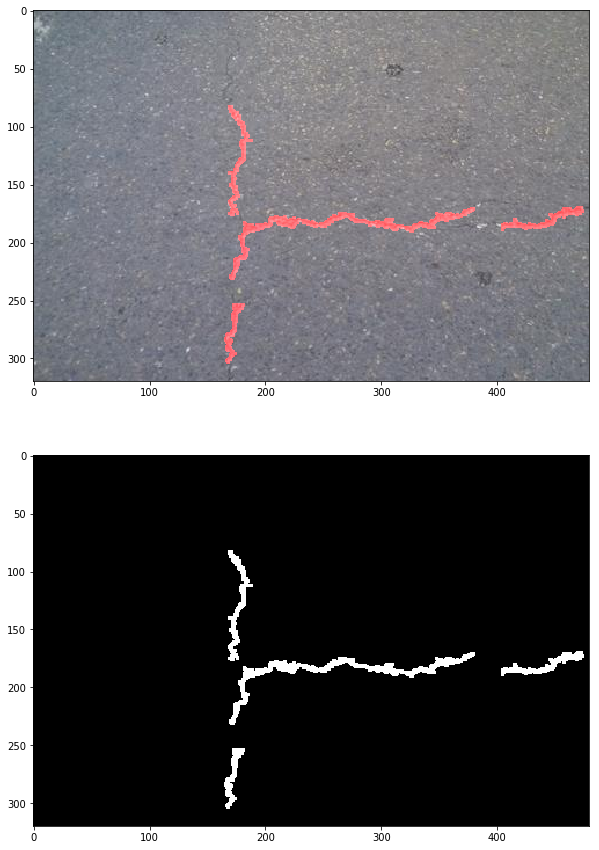

In [13]:
i = next(img_gen)
print(i) 
detect_crack(i)

### Failed sample

high contrast


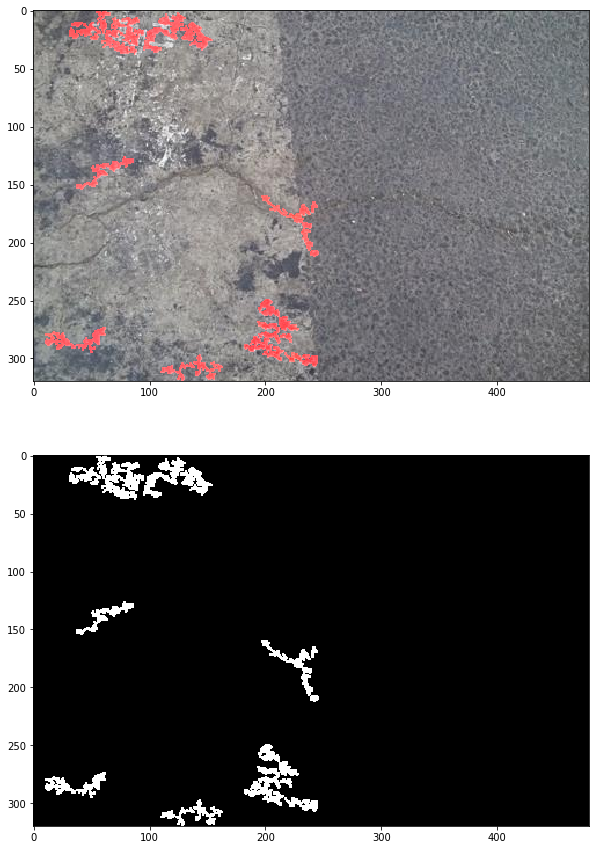

In [16]:
detect_crack(52)

## Conclusion

The program is able to accurately mark most of the samples. However, since it is based on feature analysis only, there are scenarios (such as mixed lighting conditions) where the program doesn't perform as well. If we can obtain an abundance of samples, we can use this program to mark most of the crack, and then hand label the ones where it does not perform as well. With the labeled dataset, we can train a classifier (Logistic Regression, CNN etc.) using the labeled images. Using this supervised learning approach we should be able to get a classifier that performs well in all conditions. 